In [2]:
!pip install kneed

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

In [15]:
# Set Data Extraction parameters
start_date = "2017-01-01"
end_date = "2022-06-01"
file_name = "/content/raw_data_etf.csv"
file_name_coint = "/content/raw_data_coint_pairs.csv"
load_existing = True
load_coint_pairs = True

In [16]:
# Get New or Load Existing Data
# Allow 15 mins for new data
if not load_existing:
    symbols = get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True) & (symbols["Market Category"] == "G")] # G = NASDAQ GLOBAL MARKET
    symbols = list(symbols.index.values)
    data = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]
    data.to_csv(file_name)

In [18]:
# Load (or re-load for consistency) Data and remove features with NaN's
data = pd.read_csv(file_name)
data.dropna(axis=1, inplace=True)
data = data.set_index("Date")
print("Shape: ", data.shape)
print("Null Values: ", data.isnull().values.any())
data.head()

Shape:  (1363, 265)
Null Values:  False


,AADR,AAXJ,ACWI,ACWX,ADRE,AGNG,AGZD,AIA,AIRR,ALTY,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,39.404003,50.324165,53.491852,34.928574,29.558573,14.668802,42.505810,42.452053,23.538317,9.600211,...,96.048004,45.296101,108.774231,51.274086,96.194260,63.629200,40.811722,48.171516,49.646027,25.511465
2017-01-04,40.082230,50.823139,53.949348,35.316765,29.874083,14.668802,42.602840,42.678879,23.885475,9.735156,...,97.151901,45.314533,111.057976,52.043102,97.649651,63.882755,41.262142,48.659973,50.088799,25.843027
2017-01-05,40.512093,51.539852,54.155670,35.618690,30.514109,14.668802,42.594006,43.205097,23.479965,9.807764,...,96.975655,45.369812,110.202805,51.524136,96.333328,64.291672,41.571251,49.131573,50.051899,25.928291
2017-01-06,40.378361,51.285820,54.164646,35.472038,30.081415,14.668802,42.558708,43.023640,23.479965,9.902229,...,97.226128,45.296101,109.639153,51.307114,95.814209,64.111755,41.482937,48.870510,50.051899,25.975655
2017-01-09,40.521645,51.331188,54.039059,35.420284,30.333826,14.668802,42.452873,43.141598,22.985437,9.838611,...,96.892189,45.323746,109.571121,50.962708,94.655472,64.275322,41.403458,48.735756,49.729046,26.039127


### Feature Engineering

In [19]:
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,0.090635,0.233626
AAXJ,0.086427,0.211931
ACWI,0.115902,0.184653
ACWX,0.078023,0.183579
ADRE,0.089208,0.243986


In [20]:
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,0.014753,0.311722
AAXJ,-0.038123,0.090672
ACWI,0.332246,-0.187269
ACWX,-0.143712,-0.198211
ADRE,-0.003167,0.417291


### K-Means Clustering

In [24]:
X = df_scaled.copy()
K = range(1, 15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

Optimum Clusters:  5


In [63]:
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

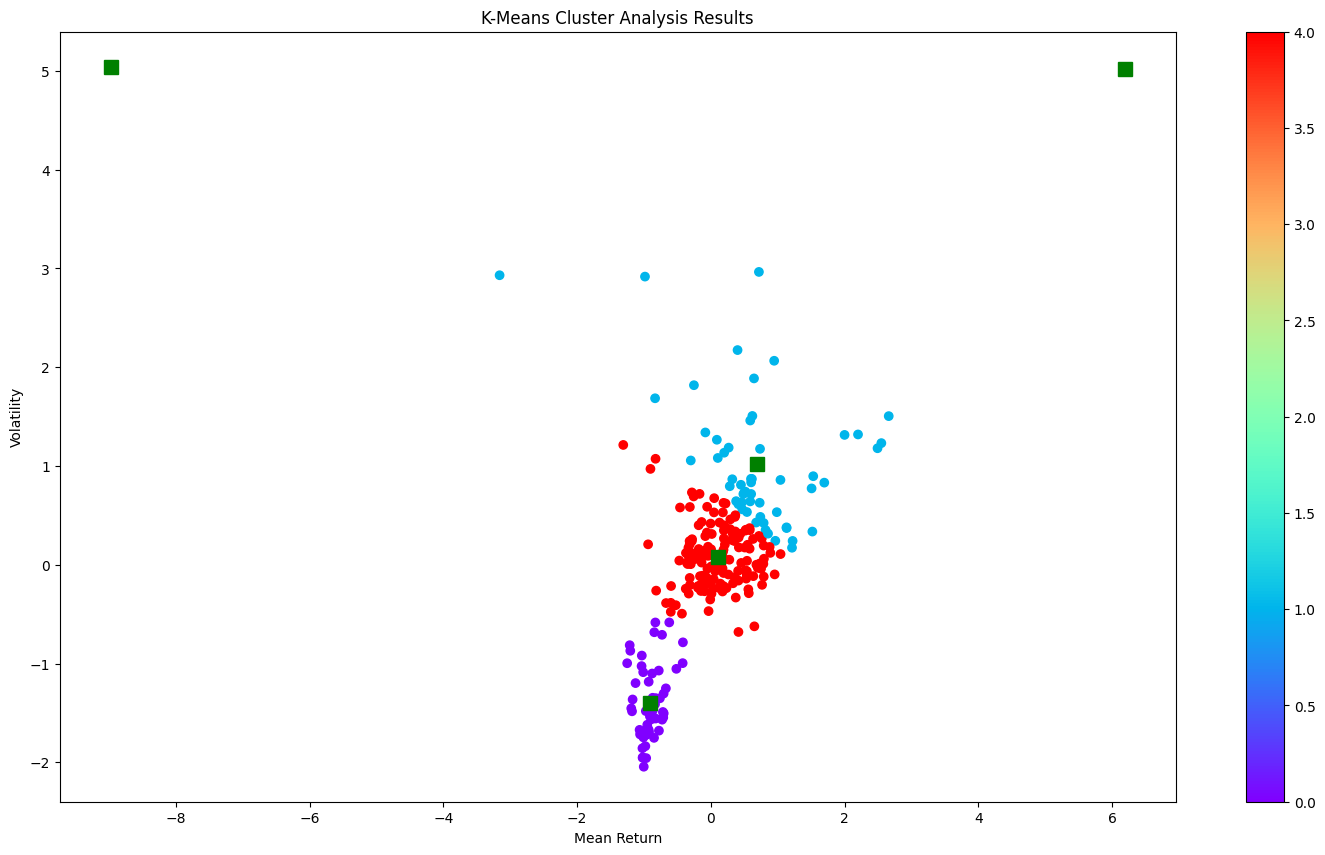

In [64]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [ ]:
# Return the series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series[:7]

AADR    0
AAXJ    0
ACWI    0
ACWX    0
ADRE    0
AGNG    0
AGZD    1
dtype: int32

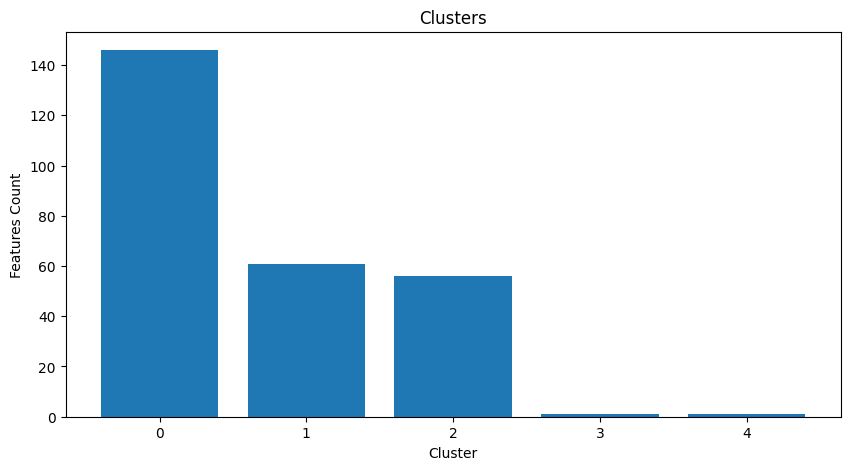

In [ ]:
# View number by cluster
plt.figure(figsize=(10, 5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")
plt.show()

In [ ]:
# Remove Items if Preferred
clusters_clean = clustered_series[clustered_series < 3]
print("Feature Number Previous: ", len(clustered_series))
print("Feature Number Current: ", len(clusters_clean))

Feature Number Previous:  265
Feature Number Current:  263


### Calculate Cointegration

In [ ]:
# Calculate cointegration
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]
    model = sm.OLS(series_1, series_2).fit()
    hedge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, hedge_ratio

In [ ]:
# Loop through and calculate cointegrated pairs
# Allow 10 - 30 mins for calculation
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs:
    for base_asset in clusters_clean.index:
        base_label = clusters_clean[base_asset]

        for compare_asset in clusters_clean.index:
            compare_label = clusters_clean[compare_asset]

            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)

            if compare_asset != base_asset and base_label == compare_label and not is_tested:

                series_1 = data[base_asset].values.astype(float)
                series_2 = data[compare_asset].values.astype(float)
                coint_flag, _ = calculate_cointegration(series_1, series_2)
                if coint_flag == 1:
                    cointegrated_pairs.append({"base_asset": base_asset,
                                               "compare_asset": compare_asset,
                                               "label": base_label})

    df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
    df_coint.to_csv(file_name_coint)

In [ ]:
# Load Cointegrated Pairs
df_coint = pd.read_csv(file_name_coint).iloc[:, 1:]
df_coint.head()

,base_asset,compare_asset,label
0,AADR,DAX,0
1,FPXI,IBB,0
2,FNX,PSCC,0
3,FNX,INDY,0
4,FNK,VYMI,0


### TSNE Plot for Visualization

In [ ]:
# Get unique list of cointegrated assets
coint_assets = [df_scaled["Returns"].values]
coint_assets.append(df_scaled["Volatility"].values)
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array([-8.97857857, -3.15892964, -2.04445115, -1.95711204, -1.95310496])

In [ ]:
# Get TSNE only returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_unique_assets)]
df_TSNE.head()

,Returns,Volatility


In [ ]:
# Compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)
X_tsne[:5]

ValueError: ignored

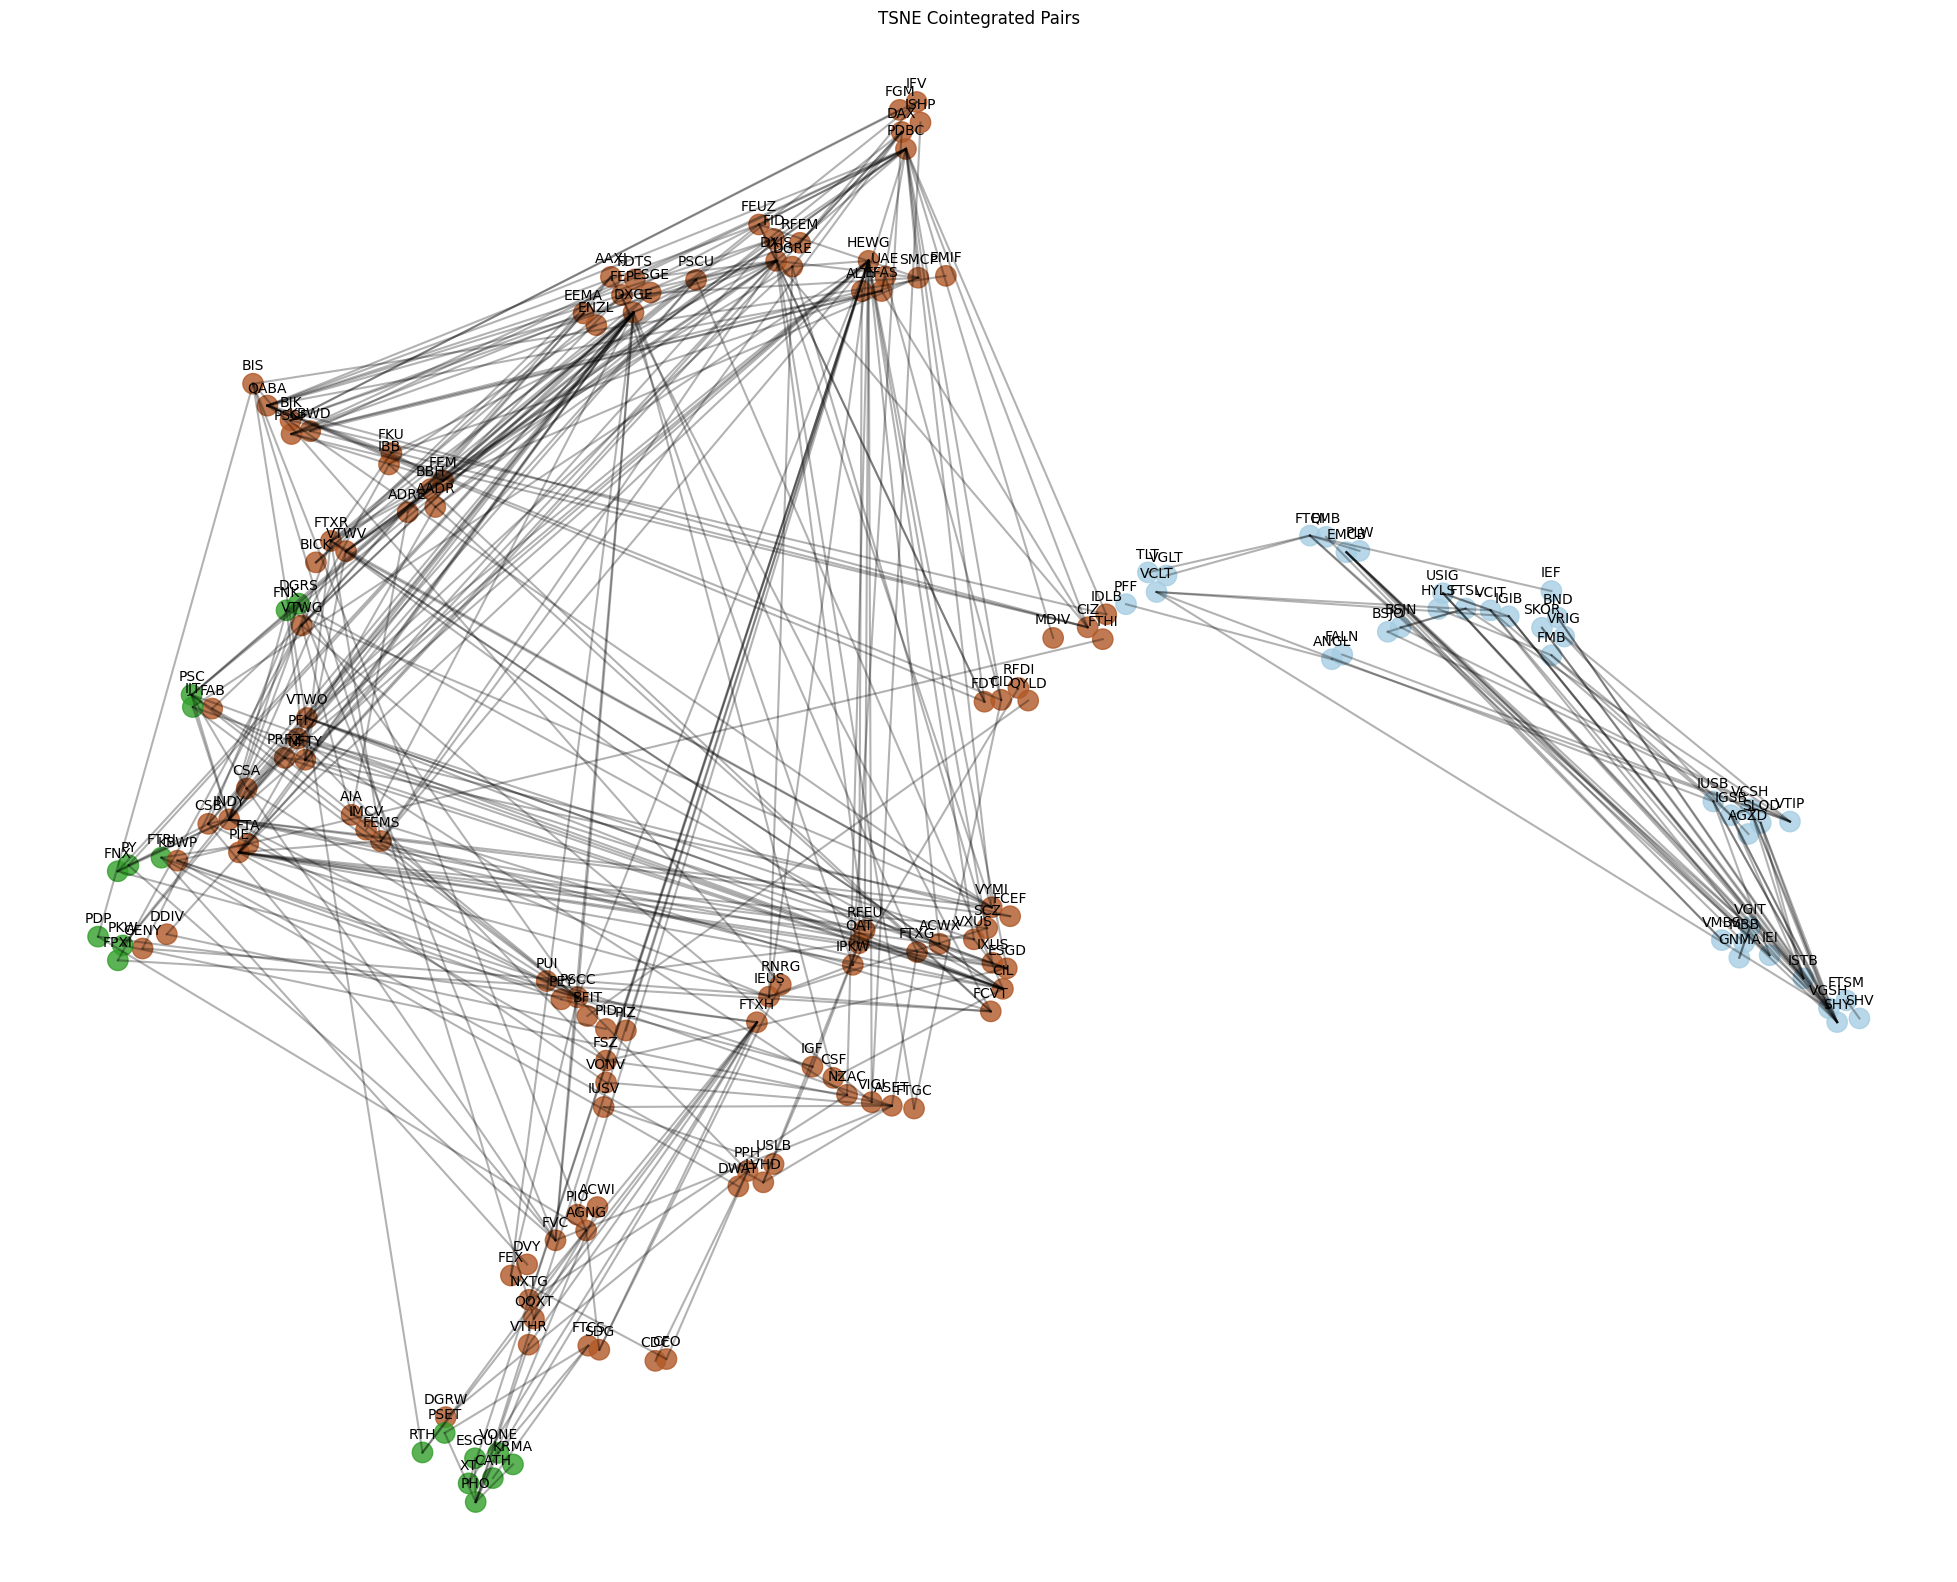

In [ ]:
# Preview TSNE
in_pairs_series = clustered_series.loc[coint_unique_assets]
plt.figure(1, figsize=(25, 20))
plt.clf()
plt.axis('off')
for index, pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Cointegrated Pairs')

# Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha="center")
plt.show()

### Review a Pair

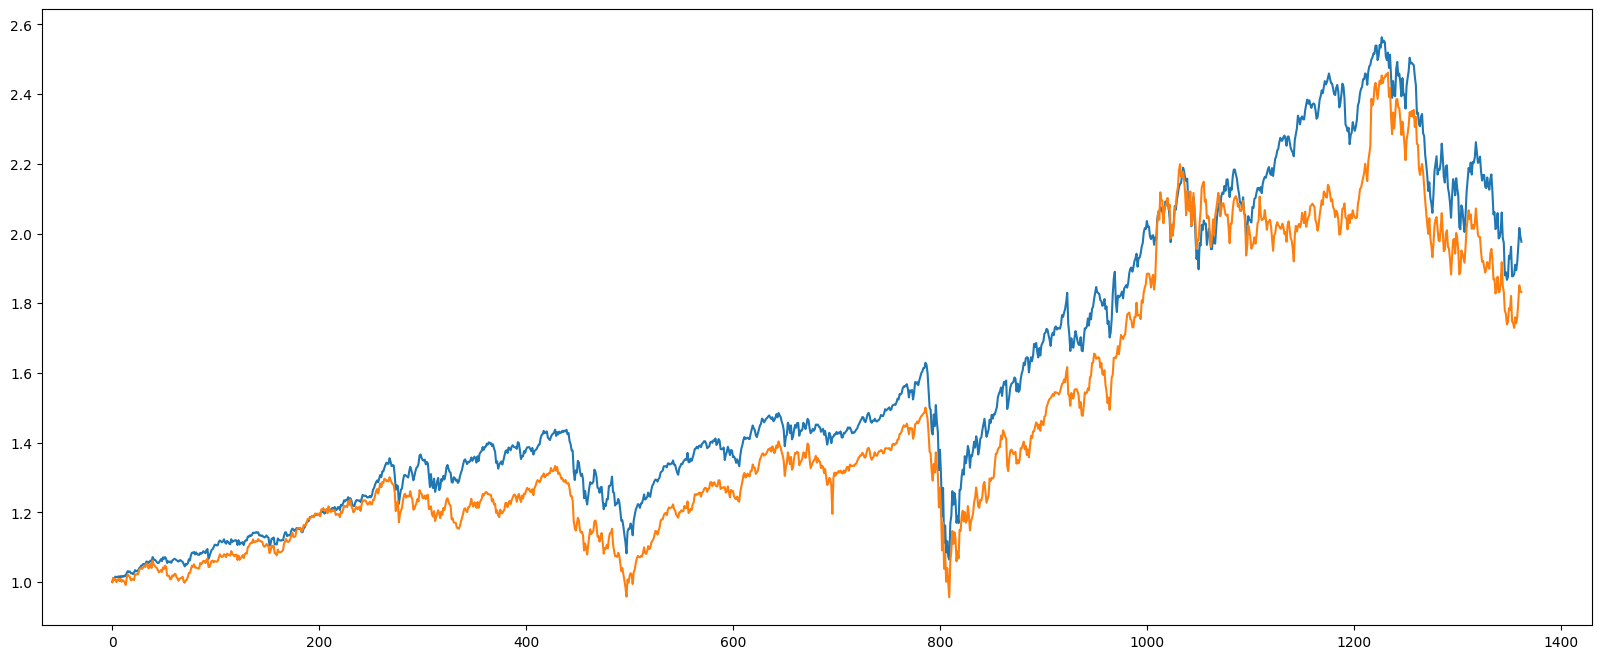

In [ ]:
# Plot price comparison for any given assets
asset_1 = "FTC"
asset_2 = "PRN"
asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()
plt.figure(1, figsize=(20, 8))
plt.plot(asset_1_values)
plt.plot(asset_2_values)
plt.show()

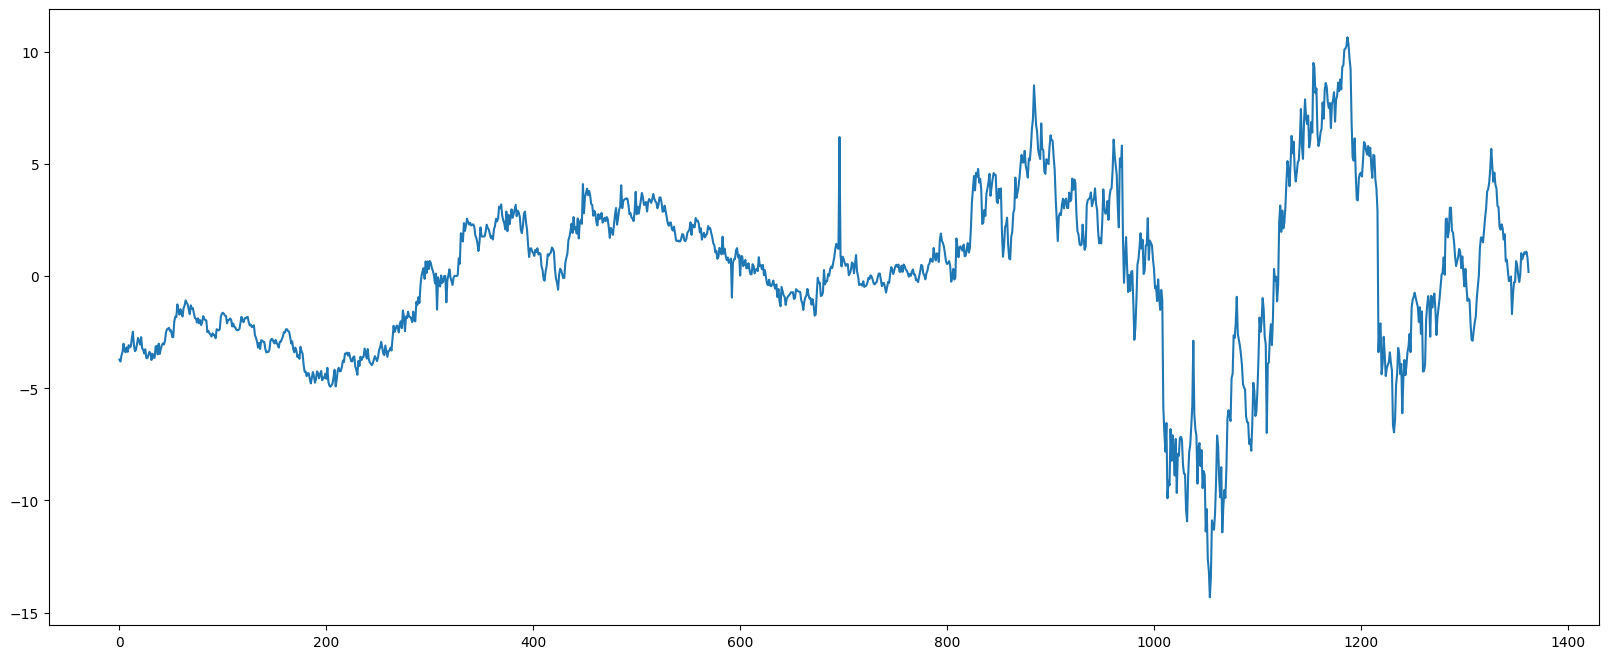

In [ ]:
# Plot the Spread
series_1 = data[asset_1].values.astype(float)
series_2 = data[asset_2].values.astype(float)
coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
spread = series_1 - (hedge_ratio * series_2)
plt.figure(1, figsize=(20, 8))
plt.plot(spread)
plt.show()

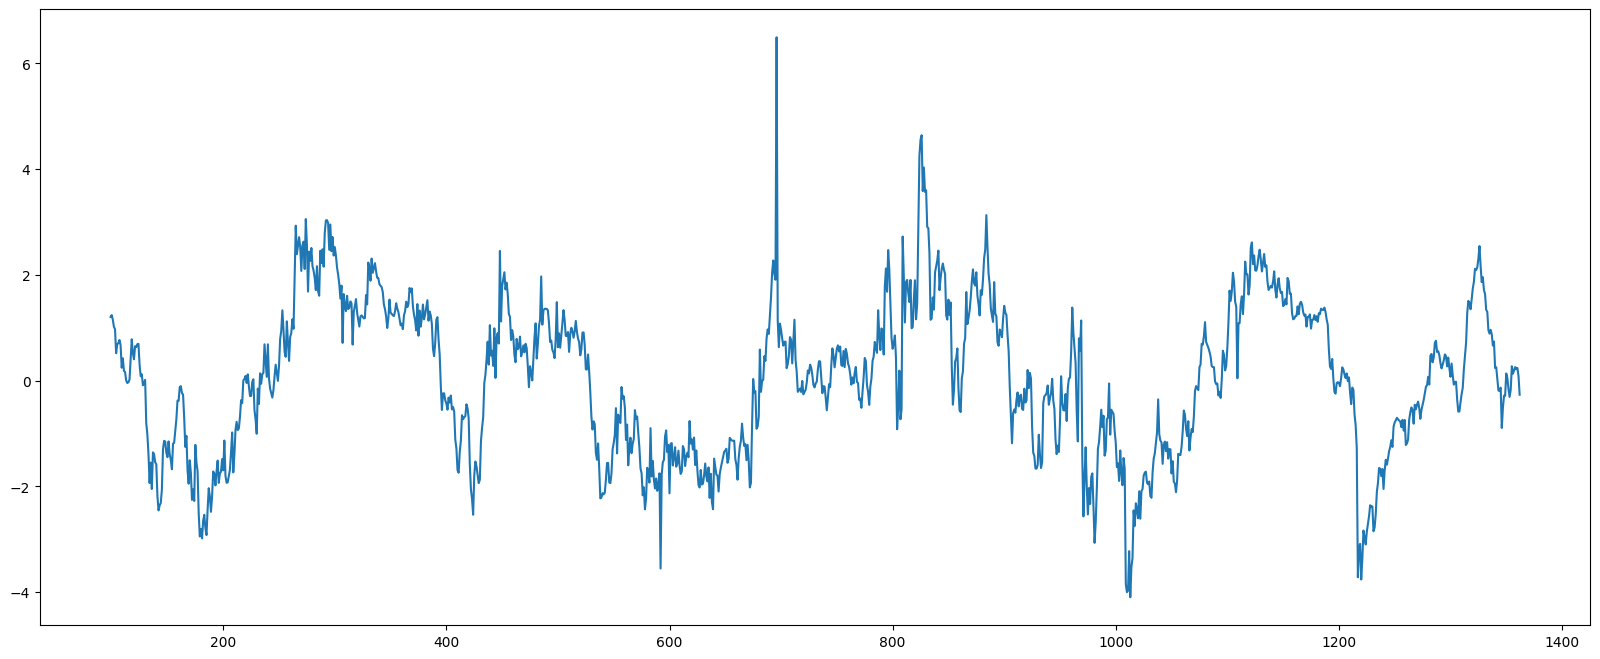

In [ ]:
# Plot the ZScore
window = 100
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std()
x = spread_series.rolling(center=False, window=1).mean()
z_score = (x - mean) / std
plt.figure(1, figsize=(20, 8))
plt.plot(z_score)
plt.show()

### Save Data

In [ ]:
# Save Data
capped = []
for z in z_score:
    z = 6 if z > 6 else z
    z = -6 if z <-6 else z
    capped.append(z)
df_save = data[[asset_1, asset_2]].copy()
df_save["Spread"] = spread
df_save["ZScore"] = capped
df_save.dropna(inplace=True)
df_save.columns = ["Asset1", "Asset2", "Spread", "ZScore"]
df_save.to_csv("/content/pair_trade.csv")
df_save.head()

,Asset1,Asset2,Spread,ZScore
Date,,,,
2017-05-25,53.630291,52.344387,-1.673399,1.204262
2017-05-26,53.620483,52.295151,-1.631186,1.238759
2017-05-30,53.532246,52.255764,-1.677811,1.156256
2017-05-31,53.571461,52.373917,-1.763428,1.019630
2017-06-01,54.061672,52.856403,-1.782981,0.973343
